In [1]:
# https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
# https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
# https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sn
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

%matplotlib inline

In [3]:
(train_examples, validation_examples, test_examples), info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:90%]', 'train[90%:95%]', 'train[95%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [4]:
num_examples, num_classes

(3670, 5)

In [5]:
info.name

'tf_flowers'

In [6]:
labels = info.features['label']

In [7]:
labels.names, labels.num_classes

(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

In [8]:
IMAGE_RES = 224

In [9]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

# train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

train_batches = train_examples.shuffle(len(train_examples)).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [10]:
url_mobilenet = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_mobilenet = hub.KerasLayer(url_mobilenet, input_shape=(IMAGE_RES,IMAGE_RES,3))

In [11]:
url_inception = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_inception = hub.KerasLayer(url_inception, input_shape=(IMAGE_RES,IMAGE_RES,3))

In [12]:
url_resnet = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
feature_extractor_resnet = hub.KerasLayer(url_resnet, input_shape=(IMAGE_RES,IMAGE_RES,3))

In [13]:
feature_extractor_mobilenet.trainable = False
feature_extractor_inception.trainable = False
feature_extractor_resnet.trainable = False

In [190]:
model_mobilenet = tf.keras.Sequential([
    feature_extractor_mobilenet,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

In [113]:
model_inception = tf.keras.Sequential([
    feature_extractor_inception,
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(num_classes)
])

In [161]:
model_resnet = tf.keras.Sequential([
    feature_extractor_resnet,
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(num_classes)
])

In [191]:
model_mobilenet.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [115]:
model_inception.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [162]:
model_resnet.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [192]:
model_mobilenet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [117]:
model_inception.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [163]:
model_resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [77]:
mcp_mobilenet = ModelCheckpoint('mobilenet_v2_model.h5')
mcp_inception = ModelCheckpoint('inception_v3_model.h5')
mcp_resnet = ModelCheckpoint('resnet_v2_50_model.h5')

In [78]:
EPOCHS = 20

In [193]:
history_mobilenet = model_mobilenet.fit(train_batches, validation_data=validation_batches, epochs=EPOCHS, callbacks=[mcp_mobilenet])

Epoch 1/20
104/104 [==============================] - 4s 33ms/step - loss: 0.9396 - accuracy: 0.6567 - val_loss: 0.3951 - val_accuracy: 0.8743
Epoch 2/20
104/104 [==============================] - 3s 30ms/step - loss: 0.5152 - accuracy: 0.8123 - val_loss: 0.3282 - val_accuracy: 0.8689
Epoch 3/20
104/104 [==============================] - 3s 30ms/step - loss: 0.4338 - accuracy: 0.8471 - val_loss: 0.2804 - val_accuracy: 0.9071
Epoch 4/20
104/104 [==============================] - 3s 30ms/step - loss: 0.3791 - accuracy: 0.8641 - val_loss: 0.2743 - val_accuracy: 0.9016
Epoch 5/20
104/104 [==============================] - 3s 30ms/step - loss: 0.3596 - accuracy: 0.8741 - val_loss: 0.3492 - val_accuracy: 0.8579
Epoch 6/20
104/104 [==============================] - 3s 30ms/step - loss: 0.3184 - accuracy: 0.8868 - val_loss: 0.2722 - val_accuracy: 0.9126
Epoch 7/20
104/104 [==============================] - 3s 30ms/step - loss: 0.3112 - accuracy: 0.8880 - val_loss: 0.2601 - val_accuracy: 0.9071

In [119]:
history_inception = model_inception.fit(train_batches, validation_data=validation_batches, epochs=EPOCHS, callbacks=[mcp_inception])

Epoch 1/20
104/104 [==============================] - 8s 66ms/step - loss: 1.2721 - accuracy: 0.5643 - val_loss: 0.6435 - val_accuracy: 0.7322
Epoch 2/20
104/104 [==============================] - 6s 62ms/step - loss: 0.8013 - accuracy: 0.7206 - val_loss: 0.5291 - val_accuracy: 0.7869
Epoch 3/20
104/104 [==============================] - 6s 62ms/step - loss: 0.6849 - accuracy: 0.7696 - val_loss: 0.5403 - val_accuracy: 0.7869
Epoch 4/20
104/104 [==============================] - 6s 62ms/step - loss: 0.5721 - accuracy: 0.7896 - val_loss: 0.4726 - val_accuracy: 0.8087
Epoch 5/20
104/104 [==============================] - 7s 63ms/step - loss: 0.5582 - accuracy: 0.8068 - val_loss: 0.4694 - val_accuracy: 0.8033
Epoch 6/20
104/104 [==============================] - 7s 63ms/step - loss: 0.4949 - accuracy: 0.8274 - val_loss: 0.4364 - val_accuracy: 0.8197
Epoch 7/20
104/104 [==============================] - 7s 63ms/step - loss: 0.5033 - accuracy: 0.8220 - val_loss: 0.4853 - val_accuracy: 0.8087

In [164]:
history_resnet = model_resnet.fit(train_batches, validation_data=validation_batches, epochs=EPOCHS, callbacks=[mcp_resnet])

Epoch 1/20
104/104 [==============================] - 9s 82ms/step - loss: 1.1290 - accuracy: 0.6079 - val_loss: 0.4534 - val_accuracy: 0.8415
Epoch 2/20
104/104 [==============================] - 8s 81ms/step - loss: 0.5943 - accuracy: 0.7999 - val_loss: 0.3943 - val_accuracy: 0.8525
Epoch 3/20
104/104 [==============================] - 8s 81ms/step - loss: 0.4833 - accuracy: 0.8295 - val_loss: 0.3862 - val_accuracy: 0.8525
Epoch 4/20
104/104 [==============================] - 8s 80ms/step - loss: 0.4337 - accuracy: 0.8526 - val_loss: 0.3750 - val_accuracy: 0.8689
Epoch 5/20
104/104 [==============================] - 8s 80ms/step - loss: 0.3904 - accuracy: 0.8650 - val_loss: 0.3414 - val_accuracy: 0.8689
Epoch 6/20
104/104 [==============================] - 8s 79ms/step - loss: 0.3816 - accuracy: 0.8689 - val_loss: 0.3478 - val_accuracy: 0.8743
Epoch 7/20
104/104 [==============================] - 8s 79ms/step - loss: 0.3679 - accuracy: 0.8647 - val_loss: 0.3418 - val_accuracy: 0.8852

In [194]:
from tensorflow.keras.models import load_model

In [195]:
test_batches = test_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [196]:
est_loss_mobilenet, test_accuracy_mobilenet = model_mobilenet.evaluate(test_batches)
print('Accuracy on test dataset for mobilenet:', test_accuracy_mobilenet)

6/6 [==============================] - 0s 34ms/step - loss: 0.2237 - accuracy: 0.9348
Accuracy on test dataset for mobilenet: 0.9347826242446899


In [197]:
est_loss_inception, test_accuracy_inception = model_inception.evaluate(test_batches)
print('Accuracy on test dataset for inception:', test_accuracy_inception)

6/6 [==============================] - 0s 69ms/step - loss: 0.2821 - accuracy: 0.8859
Accuracy on test dataset for inception: 0.885869562625885


In [198]:
est_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_batches)
print('Accuracy on test dataset for resnet:', test_accuracy_resnet)

6/6 [==============================] - 1s 78ms/step - loss: 0.1865 - accuracy: 0.9348
Accuracy on test dataset for resnet: 0.9347826242446899


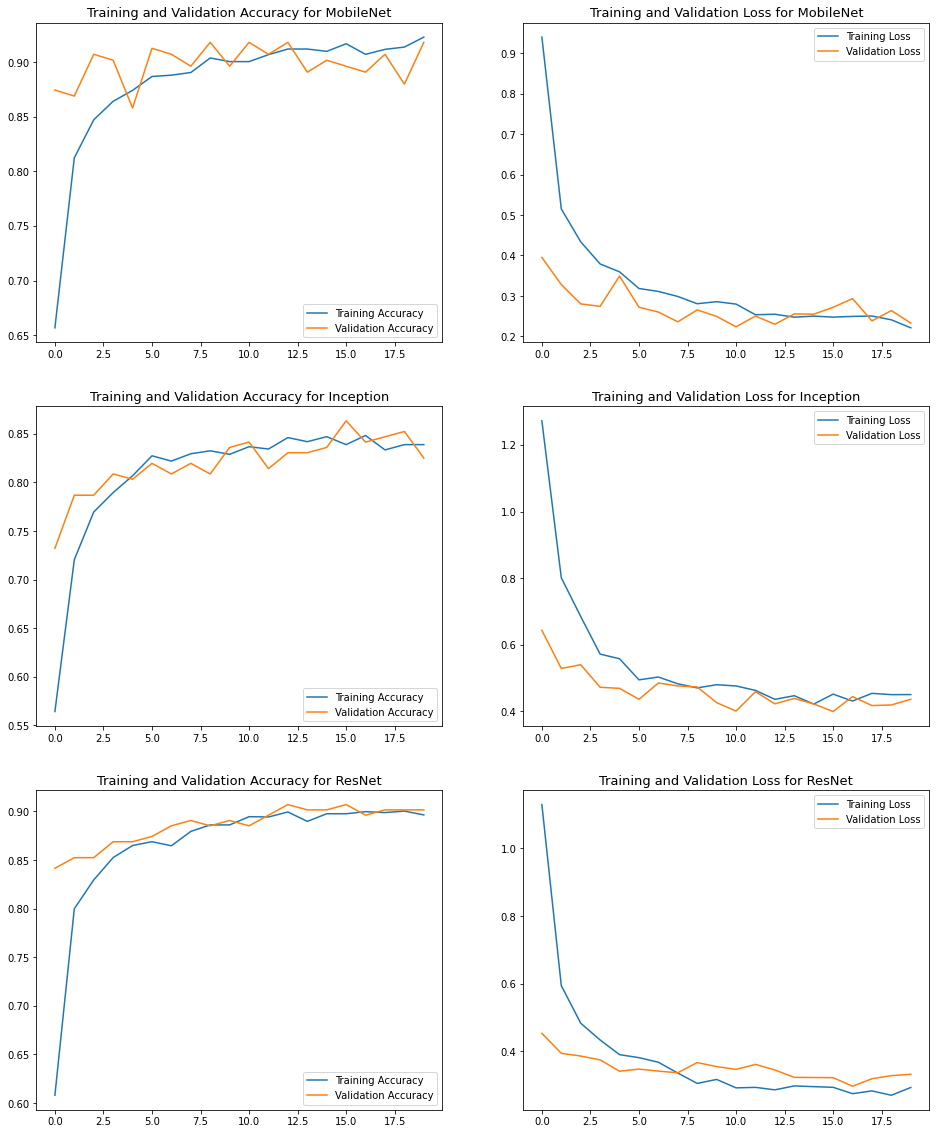

In [199]:
acc_mobilenet = history_mobilenet.history['accuracy']
val_acc_mobilenet = history_mobilenet.history['val_accuracy']

loss_mobilenet = history_mobilenet.history['loss']
val_loss_mobilenet = history_mobilenet.history['val_loss']

acc_inception = history_inception.history['accuracy']
val_acc_inception = history_inception.history['val_accuracy']

loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']

acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 20))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc_mobilenet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_mobilenet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for MobileNet', fontsize=13)

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss_mobilenet, label='Training Loss')
plt.plot(epochs_range, val_loss_mobilenet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet', fontsize=13)

plt.subplot(3, 2, 3)
plt.plot(epochs_range, acc_inception, label='Training Accuracy')
plt.plot(epochs_range, val_acc_inception, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for Inception', fontsize=13)

plt.subplot(3, 2, 4)
plt.plot(epochs_range, loss_inception, label='Training Loss')
plt.plot(epochs_range, val_loss_inception, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for Inception', fontsize=13)

plt.subplot(3, 2, 5)
plt.plot(epochs_range, acc_resnet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_resnet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for ResNet', fontsize=13)

plt.subplot(3, 2, 6)
plt.plot(epochs_range, loss_resnet, label='Training Loss')
plt.plot(epochs_range, val_loss_resnet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for ResNet', fontsize=13)

plt.show()

In [200]:
len(train_examples), len(validation_examples), len(test_examples)

(3303, 183, 184)

In [201]:
preds_mobilenet = model_mobilenet.predict(test_batches)
preds_inception = model_inception.predict(test_batches)
preds_resnet = model_resnet.predict(test_batches)

In [202]:
preds_mobilenet[0]

array([-5.138228 , -6.894891 ,  2.534635 , -8.390377 , -1.4021063],
      dtype=float32)

In [203]:
preds_inception[0]

array([-5.899363 , -6.945919 ,  1.5868064, -5.462312 , -2.9914422],
      dtype=float32)

In [204]:
preds_resnet[0]

array([ -9.289915 ,  -7.1960444,   5.3334436, -13.155905 ,  -9.922506 ],
      dtype=float32)

In [205]:
pred_mobilenet_labels = np.argmax(preds_mobilenet[:], axis=1)
pred_inception_labels = np.argmax(preds_inception[:], axis=1)
pred_resnet_labels = np.argmax(preds_resnet[:], axis=1)

In [206]:
test_labels = []
for _, label in test_examples.take(len(test_examples)):
    test_labels.append(label.numpy())

In [207]:
test_labels[0], pred_mobilenet_labels[0], pred_inception_labels[0], pred_resnet_labels[0]

(2, 2, 2, 2)

In [208]:
from sklearn.metrics import confusion_matrix

In [209]:
confusion_matrix(test_labels, pred_mobilenet_labels)

array([[38,  0,  0,  1,  0],
       [ 2, 29,  0,  1,  0],
       [ 1,  1, 43,  1,  0],
       [ 0,  2,  2, 36,  0],
       [ 0,  1,  0,  0, 26]])

In [210]:
confusion_matrix(test_labels, pred_inception_labels)

array([[37,  0,  1,  1,  0],
       [ 1, 30,  0,  1,  0],
       [ 3,  0, 39,  1,  3],
       [ 2,  2,  1, 33,  2],
       [ 0,  0,  3,  0, 24]])

In [211]:
confusion_matrix(test_labels, pred_resnet_labels)

array([[38,  0,  0,  1,  0],
       [ 2, 29,  0,  1,  0],
       [ 0,  0, 43,  1,  2],
       [ 0,  0,  1, 37,  2],
       [ 0,  0,  1,  1, 25]])

In [212]:
array_mobilenet = confusion_matrix(test_labels, pred_mobilenet_labels)
df_mobilenet = pd.DataFrame(array_mobilenet, index = [i for i in labels.names],
                  columns = [i for i in labels.names])

In [213]:
array_inception = confusion_matrix(test_labels, pred_inception_labels)
df_inception = pd.DataFrame(array_inception, index = [i for i in labels.names],
                  columns = [i for i in labels.names])

In [214]:
array_resnet = confusion_matrix(test_labels, pred_resnet_labels)
df_resnet = pd.DataFrame(array_resnet, index = [i for i in labels.names],
                  columns = [i for i in labels.names])

In [215]:
df_mobilenet

,dandelion,daisy,tulips,sunflowers,roses
dandelion,38,0,0,1,0
daisy,2,29,0,1,0
tulips,1,1,43,1,0
sunflowers,0,2,2,36,0
roses,0,1,0,0,26


In [216]:
df_inception

,dandelion,daisy,tulips,sunflowers,roses
dandelion,37,0,1,1,0
daisy,1,30,0,1,0
tulips,3,0,39,1,3
sunflowers,2,2,1,33,2
roses,0,0,3,0,24


In [217]:
df_resnet

,dandelion,daisy,tulips,sunflowers,roses
dandelion,38,0,0,1,0
daisy,2,29,0,1,0
tulips,0,0,43,1,2
sunflowers,0,0,1,37,2
roses,0,0,1,1,25


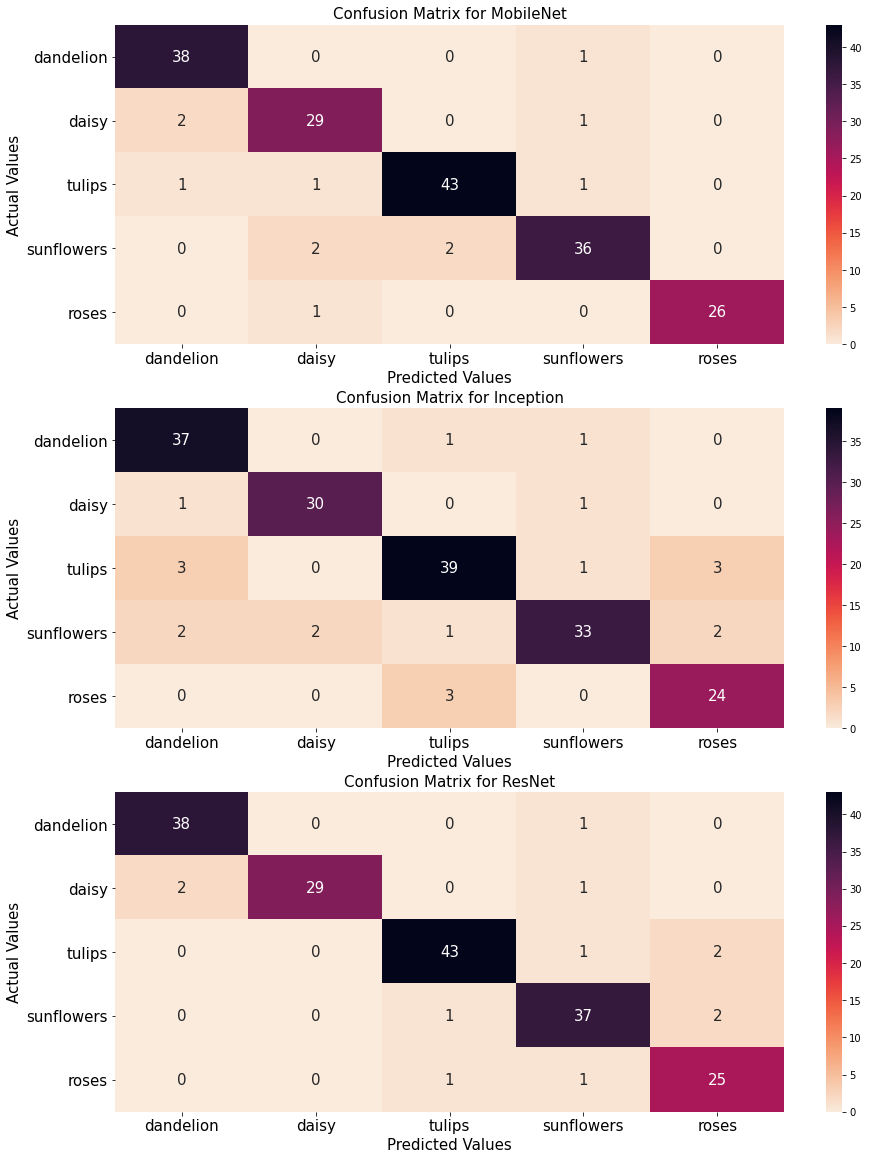

In [218]:
plt.figure(figsize = (15,20))

plt.subplot(3, 1, 1)
sn.heatmap(df_mobilenet, cmap="rocket_r", annot=True, fmt="d", annot_kws={"size": 15})
plt.ylabel("Actual Values", fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.xlabel("Predicted Values", fontsize=15)
plt.xticks(fontsize=15)
plt.title('Confusion Matrix for MobileNet', fontsize=15)

plt.subplot(3, 1, 2)
sn.heatmap(df_inception, cmap="rocket_r", annot=True, fmt="d", annot_kws={"size": 15})
plt.ylabel("Actual Values", fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.xlabel("Predicted Values", fontsize=15)
plt.xticks(fontsize=15)
plt.title('Confusion Matrix for Inception', fontsize=15)

plt.subplot(3, 1, 3)
sn.heatmap(df_resnet, cmap="rocket_r", annot=True, fmt="d", annot_kws={"size": 15})
plt.ylabel("Actual Values", fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.xlabel("Predicted Values", fontsize=15)
plt.xticks(fontsize=15)
plt.title('Confusion Matrix for ResNet', fontsize=15)

plt.show();